# A fast simple algorithm to find all paths up length 4 between two nodes

**Author:** Alexei Stepanenko

**Overview:** We introduce a simple path-finding algorithm which may be implemented using distributed table to table operations. It is shown to be clearly significantly faster than neo4j (based on experience of previous neo4j runtimes). This notebook therefore indicates that we should move away neo4j for path-finding in the MOA pipeline and instead use distributed table to table operations. 

**Description of algorithm:** Consider an undirected graph. Consider a source node $s$ and a target node $t$. We wish to find all paths from $s$ to $t$ of length at most 4.

Let $\mathcal{N}_1(n)$ be the set of all 1-hop neighbors of a node $n$.

Let $\mathcal{N}_2(s) = \{(a_j,b_j)\}_{j}$ be the set of all 2-hop paths originating from $s$, Each path is represented by a pair of nodes $(a_j,b_j)$ such that $a_j \in \mathcal{N}_1(s)$ and $b_j \in \mathcal{N}_1(a_j)$.

Define $\mathcal{N}_2(t) = \{(c_j,d_j)\}_{j}$ similarly for the target node.

The set of two-hop paths is given by
$$
\mathcal{P}_2(s,t) = \{(s, a, t) : a \in \mathcal{N}_1(s) \cap \mathcal{N}_1(t)\}.
$$
The set of three-hop paths is given by
$$
\mathcal{P}_3(s,t) = \{(s, a, b, t) : (a,b) \in \mathcal{N}_2(s)\text{ and } b \in \mathcal{N}_1(t)\}.
$$
The set of four-hop paths is given by
$$
\mathcal{P}_4(s,t) = \{(s, a, b, c, t) : (a,b) \in \mathcal{N}_2(s), \, (c, d) \in \mathcal{N}_2(t) \text{ and } b = d\}.
$$

These formulas allow for the fast computation of the paths since $\mathcal{N}_1(n)$ and  $\mathcal{N}_2(n)$ may be computed using a "neighbours" function from standard graph libraries (alternatively we may use a join operation).  

The sets $\mathcal{P}_2(s,t)$,  $\mathcal{P}_3(s,t)$,  $\mathcal{P}_4(s,t)$ may then be computed using join operations.

**Result:** Below is a suboptimal proof of concept implementation in `polars` and `igraph`. It is shown that this algorithm is able to compute the the set of connecting paths for 1000 ground truth pairs in RTX v2.7.3 (KGML-xDTD version) in around 2 minutes on a Mac laptop.

From experience this is clearly significantly faster than neo4j (potentially several orders of magnitude).

**Future:** The algorithm may be implemented in pure PySpark which we expect would be faster still and optimised for performance on a Kubernetes cluster.

In [1]:
import matplotlib.pyplot as plt

import igraph as ig
from tqdm import tqdm
import polars as pl
import time

In [2]:
# Ground truth positive
df_tp = pl.read_csv('/Users/alexei/Documents/data/KGML_xDTD_data/known_pairs/tp_pairs.txt', separator='\t')

In [3]:
# Load nodes and edges
nodes = pl.read_csv('/Users/alexei/Documents/data/KGML_xDTD_data/KG/v2.7.3/rtx_kg2_nodes.tsv', separator='\t')
edges = pl.read_csv('/Users/alexei/Documents/data/KGML_xDTD_data/KG/v2.7.3/rtx_kg2_edges.tsv', separator='\t', has_header=False, new_columns=["subject", "object"])

In [4]:
# Construct graph and corresponding ground truth tuples
g = ig.Graph.DataFrame(edges.to_pandas(), directed=True)
key_dict = {id_val: idx for idx, id_val in enumerate(nodes["id"])}
gt_tuples = [(key_dict[subject], key_dict[object]) for subject, object in zip(df_tp["source"], df_tp["target"])]

In [5]:
def get_number_of_paths(g : ig.Graph, source_node : int, target_node : int) -> tuple[int, int, int]:
    """
    Get the number of 2-hop, 3-hop, and 4-hop paths between a source and target node.

    Args:
        g (igraph.Graph): The graph to search over.
        source_node (int): The source node.
        target_node (int): The target node.
    """

    nhood_s_0_df = pl.DataFrame({"node_0": [source_node]})
    nhood_t_0_df = pl.DataFrame({"node_m0": [target_node]})

    # Get 1-hop outgoing paths
    nhood_s_1_df = (nhood_s_0_df
                .with_columns(pl.col("node_0")
                            .map_elements(lambda x: g.neighbors(x, mode="all"), return_dtype=pl.List(pl.Int64))
                            .alias("neighbors"))
                .explode("neighbors")
                .rename({"neighbors": "node_1"}))

    nhood_t_1_df = (nhood_t_0_df
                    .with_columns(pl.col("node_m0")
                                .map_elements(lambda x: g.neighbors(x, mode="all"), return_dtype=pl.List(pl.Int64))
                                .alias("neighbors"))
                    .explode("neighbors")
                    .rename({"neighbors": "node_m1"}))
    
    # Get 2-hop outgoing paths
    nhood_s_2_df = (nhood_s_1_df
                .with_columns(pl.col("node_1")
                            .map_elements(lambda x: g.neighbors(x), return_dtype=pl.List(pl.Int64))
                            .alias("neighbors"))
                .explode("neighbors")
                .rename({"neighbors": "node_2"}))

    nhood_t_2_df = (nhood_t_1_df
                    .with_columns(pl.col("node_m1")
                                .map_elements(lambda x: g.neighbors(x), return_dtype=pl.List(pl.Int64))
                                .alias("neighbors"))
                    .explode("neighbors")
                    .rename({"neighbors": "node_m2"}))
    
    # Compute paths
    two_hop_paths = nhood_s_1_df.join(nhood_t_1_df.rename({"node_m1": "node_1"}), on="node_1", how="inner")
    three_hop_paths = nhood_s_2_df.join(nhood_t_1_df.rename({"node_m1": "node_2"}), on="node_2", how="inner")
    four_hop_paths = nhood_s_2_df.join(nhood_t_2_df.rename({"node_m1": "node_3", "node_m2": "node_2"}), on="node_2", how="inner")

    return len(two_hop_paths), len(three_hop_paths), len(four_hop_paths) 


In [6]:
N = 1000

a = time.time()
len_lst = []
for pair_index in tqdm(range(N)):
    len_lst.append(get_number_of_paths(g, gt_tuples[pair_index][0], gt_tuples[pair_index][1]))
b = time.time()
print(f"Time taken: {b - a} seconds")


100%|██████████| 1000/1000 [02:02<00:00,  8.15it/s]

Time taken: 122.72656393051147 seconds


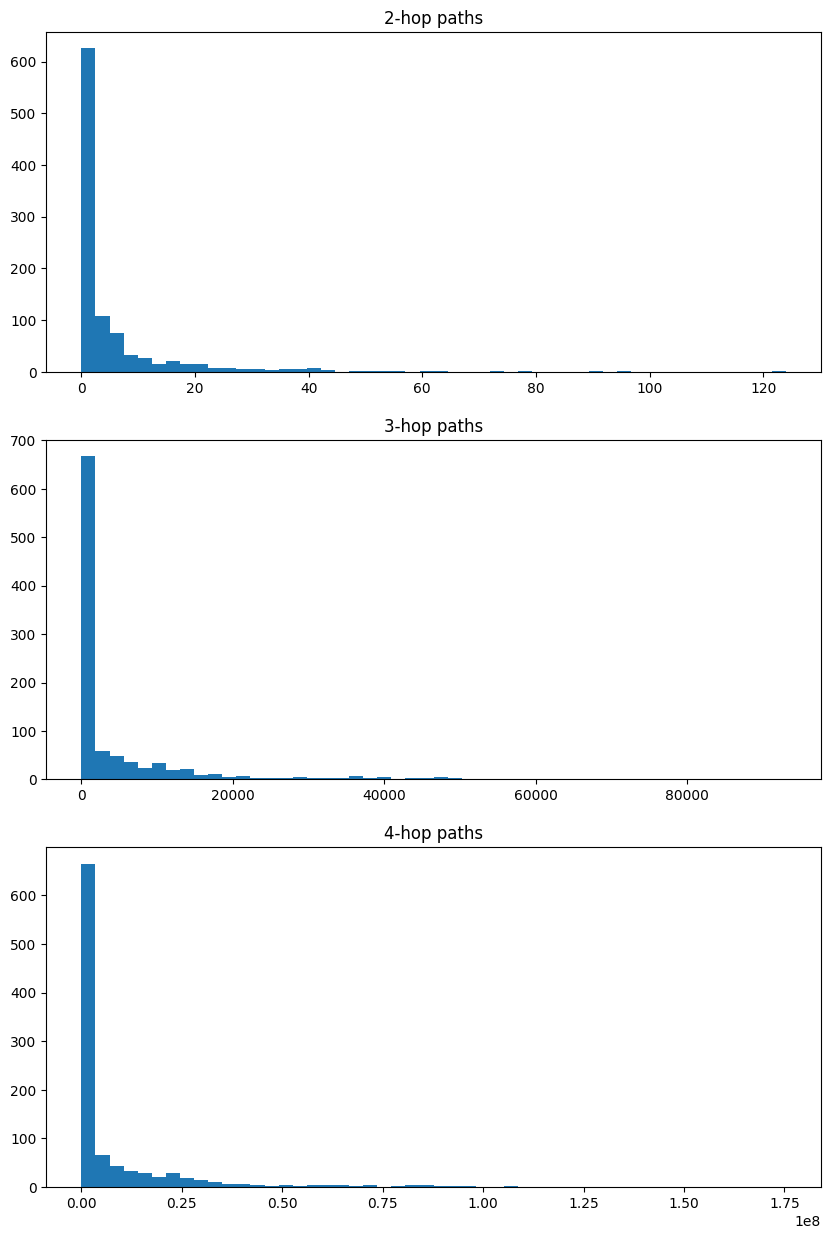

In [7]:
two_hop_lens = [len_lst[i][0] for i in range(len(len_lst))]
three_hop_lens = [len_lst[i][1] for i in range(len(len_lst))]
four_hop_lens = [len_lst[i][2] for i in range(len(len_lst))]

fig, ax = plt.subplots(3, 1, figsize=(10, 15))
ax[0].hist(two_hop_lens, bins=50)
ax[0].set_title("2-hop paths")
ax[1].hist(three_hop_lens, bins=50)
ax[1].set_title("3-hop paths")
ax[2].hist(four_hop_lens, bins=50)
ax[2].set_title("4-hop paths")
plt.show()

**Side note:** We can see from these plots that the number of two, three and four hop paths are correlated.